# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import folium
import json
from IPython.display import Image
import ipywidgets as widgets
from ipywidgets import fixed

# 0.1. Helper Functions

# 0.2. Loading Data

In [2]:
df_cab_data_raw = pd.read_csv('DataSets/Cab_Data.csv', low_memory=False) 
df_city_raw = pd.read_csv('DataSets/City.csv', low_memory=False)
df_customer_id_raw = pd.read_csv('DataSets/Customer_ID.csv', low_memory=False)
df_states_raw = pd.read_csv('DataSets/states.csv', low_memory=False)
df_transaction_id_raw = pd.read_csv('DataSets/Transaction_ID.csv', low_memory=False)
df_us_holidays_raw = pd.read_csv('DataSets/us-federal-holidays-2011-2020.csv', low_memory=False)

# merge datasets
df_raw = pd.merge(df_cab_data_raw, df_transaction_id_raw, how='left', on='Transaction ID')
df_raw_1 = pd.merge(df_raw, df_customer_id_raw, how='left', on='Customer ID')

# Renaming column Date of Travel
df_raw_1.rename(columns={'Date of Travel':'Date'}, inplace=True)

df_raw_2 = pd.merge(df_raw_1, df_us_holidays_raw, how='left', on='Date')
df_raw_2


with open('DataSets/us-states.json') as geofile:
  geofile= json.load(geofile)
geofile = json.dumps(geofile)
geofile = json.loads(geofile)

# 1.0. STEP 01 - DATA DESCRIPTION

In [3]:
df1 = df_raw_2.copy()

## 1.1. Rename Columns

In [4]:
df1.columns

Index(['Transaction ID', 'Date', 'Company', 'City', 'KM Travelled',
       'Price Charged', 'Cost of Trip', 'Customer ID', 'Payment_Mode',
       'Gender', 'Age', 'Income (USD/Month)', 'Holiday'],
      dtype='object')

In [5]:
df1.columns = ['transaction_id', 'date', 'company', 'city', 'km_travelled',
       'price_charged', 'cost_of_trip', 'customer_id', 'payment_mode',
       'gender', 'age', 'income_USD_month', 'holiday']

In [6]:
df1.columns

Index(['transaction_id', 'date', 'company', 'city', 'km_travelled',
       'price_charged', 'cost_of_trip', 'customer_id', 'payment_mode',
       'gender', 'age', 'income_USD_month', 'holiday'],
      dtype='object')

In [7]:
df1

,transaction_id,date,company,city,km_travelled,price_charged,cost_of_trip,customer_id,payment_mode,gender,age,income_USD_month,holiday
0,10000011,1/8/2016,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,NaN
1,10000012,1/6/2016,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,NaN
2,10000013,1/2/2016,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash,Male,53,11242,NaN
3,10000014,1/7/2016,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,28020,Cash,Male,23,23327,NaN
4,10000015,1/3/2016,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,27182,Card,Male,33,8536,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359387,10440101,1/8/2018,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,52392,Cash,Male,24,15651,NaN
359388,10440104,1/4/2018,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,53286,Cash,Male,32,6528,NaN
359389,10440105,1/5/2018,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,52265,Cash,Male,56,7966,NaN
359390,10440106,1/5/2018,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,52175,Card,Male,32,6423,NaN


## 1.2. Data Dimensions

In [8]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 359392
Number of Columns: 13


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date']) 
df1.dtypes 

transaction_id               int64
date                datetime64[ns]
company                     object
city                        object
km_travelled               float64
price_charged              float64
cost_of_trip               float64
customer_id                  int64
payment_mode                object
gender                      object
age                          int64
income_USD_month             int64
holiday                     object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum() 

transaction_id           0
date                     0
company                  0
city                     0
km_travelled             0
price_charged            0
cost_of_trip             0
customer_id              0
payment_mode             0
gender                   0
age                      0
income_USD_month         0
holiday             352328
dtype: int64

## 1.5. Fillout NA using business logic

In [11]:
# holiday
# Replacing all NaN values for 'Regular day'
df1['holiday'] = df1['holiday'].replace(np.nan, 'Regular day', regex=True)

In [12]:
df1.isna().sum()

transaction_id      0
date                0
company             0
city                0
km_travelled        0
price_charged       0
cost_of_trip        0
customer_id         0
payment_mode        0
gender              0
age                 0
income_USD_month    0
holiday             0
dtype: int64

## 1.6. Descriptive Statistical

### 1.6.1 Numerical Atributes

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [14]:
#central tendency - mean, median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T 
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

#dispersion - std, min ,max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T # range
d5 = pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T # skew
d6 = pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T # kurtosis

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [15]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,transaction_id,10000011.00,10440107.00,440096.00,10220761.19,10221035.50,126805.63,0.00,-1.20
1,km_travelled,1.90,48.00,46.10,22.57,22.44,12.23,0.06,-1.13
2,price_charged,15.60,2048.03,2032.43,423.44,386.36,274.38,0.87,0.75
3,cost_of_trip,19.00,691.20,672.20,286.19,282.48,157.99,0.14,-1.01
4,customer_id,1.00,60000.00,59999.00,19191.65,7459.00,21012.38,0.88,-0.89
5,age,18.00,65.00,47.00,35.34,33.00,12.59,0.69,-0.46
6,income_USD_month,2000.00,35000.00,33000.00,15048.82,14685.00,7969.40,0.31,-0.66


### 1.7.2 Categorical Atributes

In [16]:
# For categorical variables it is used boxplot, which shows all central and dispersion meassures in one place.
# Also show outiers.
cat_attributes.apply(lambda x: x.unique().shape[0])

company          2
city            19
payment_mode     2
gender           2
holiday         11
dtype: int64

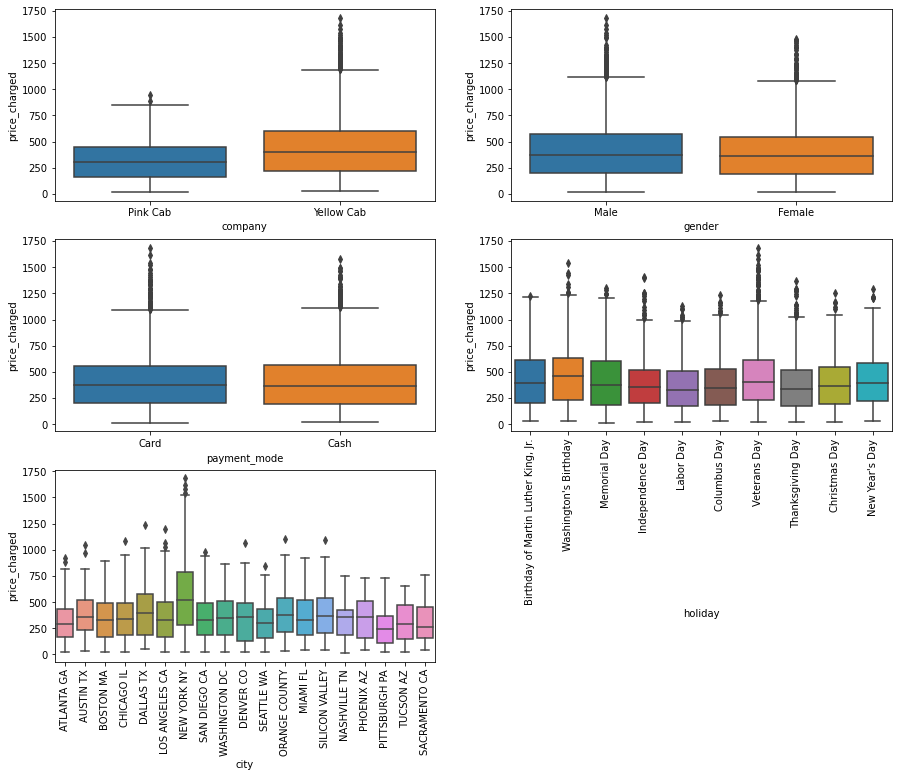

In [17]:
aux1 = df1[(df1['holiday'] != 'Regular day') & (df1['price_charged'] > 0)]

fig = plt.figure(figsize=(15,12)) 

fig.add_subplot(3,2,1)
sns.boxplot(x = 'company', y = 'price_charged', data = aux1)

fig.add_subplot(3,2,2)
sns.boxplot(x = 'gender', y = 'price_charged', data = aux1)

fig.add_subplot(3,2,3)
sns.boxplot(x = 'payment_mode', y = 'price_charged', data = aux1)

fig.add_subplot(3,2,4)
sns.boxplot(x = 'holiday', y = 'price_charged', data = aux1)
plt.xticks(rotation=90);

fig.add_subplot(3,2,5)
sns.boxplot(x = 'city', y = 'price_charged', data = aux1)
plt.xticks(rotation=90);

# 2.0. STEP 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

In [19]:
#creating profit variable
df2['profit'] = (df2['price_charged'] - df2['cost_of_trip']).apply(lambda x : x)


# separating varialbe date

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

#year month
df2['year_month'] = df2['date'].dt.strftime('%Y-%m')

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#month_day
df2['month_day'] = pd.to_datetime(df2['date']).dt.strftime('%m-%d')

# #creating variables season
df2['season'] = df2.apply(lambda x: 'spring' if (x['month_day'] >='03-01') & (x['month_day'] <='05-31') else
                                    'summer' if (x['month_day'] >='06-01') & (x['month_day'] <='08-31') else 
                                    'fall'   if (x['month_day'] >='09-01') & (x['month_day'] <='11-30') else
                                    'winter', axis = 1)

# Followign the Business Assumptions from README, it will be added the state code for the cities SILICON VALLEY and ORANGE COUNTY,
# that is CAlofornia CA for both
df2['city'] = df2['city'].apply(lambda x: 'SILICON VALLEY CA' if x == 'SILICON VALLEY' else 
                                                          'ORANGE COUNTY CA' if x == 'ORANGE COUNTY'   else x)

# spilt city in two columns
new = df2['city'].str.rsplit(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
df2["cities"]= new[0]
  
# making separate last name column from new data frame
df2["State Code"]= new[1]
  
# Dropping old Name columns
df2.drop(columns =["city"], inplace = True)

# merge df2 with dataset df_states_raw
df2 = pd.merge(df2, df_states_raw, how='left', on='State Code')

# Renaming column State Code
df2.rename(columns={'State Code':'state_code', 'State':'state', 'Region':'region', 'Division':'division'}, inplace=True)

# drop column State
df2 = df2.drop('state', axis =1)

# 3.0. - Step 03 - Numerical Outliers Detection

In [181]:
df3 = df2.copy()

In [182]:
a = df3.select_dtypes(include=['int64', 'float64'])
a.head()

,transaction_id,km_travelled,price_charged,cost_of_trip,customer_id,age,income_USD_month,profit,year,month,day
0,10000011,30.45,370.95,313.63,29290,28,10813,57.31,2016,1,8
1,10000012,28.62,358.52,334.85,27703,27,9237,23.67,2016,1,6
2,10000013,9.04,125.20,97.63,28712,53,11242,27.57,2016,1,2
3,10000014,33.17,377.40,351.60,28020,23,23327,25.80,2016,1,7
4,10000015,8.73,114.62,97.78,27182,33,8536,16.84,2016,1,3


<AxesSubplot:xlabel='income_USD_month'>

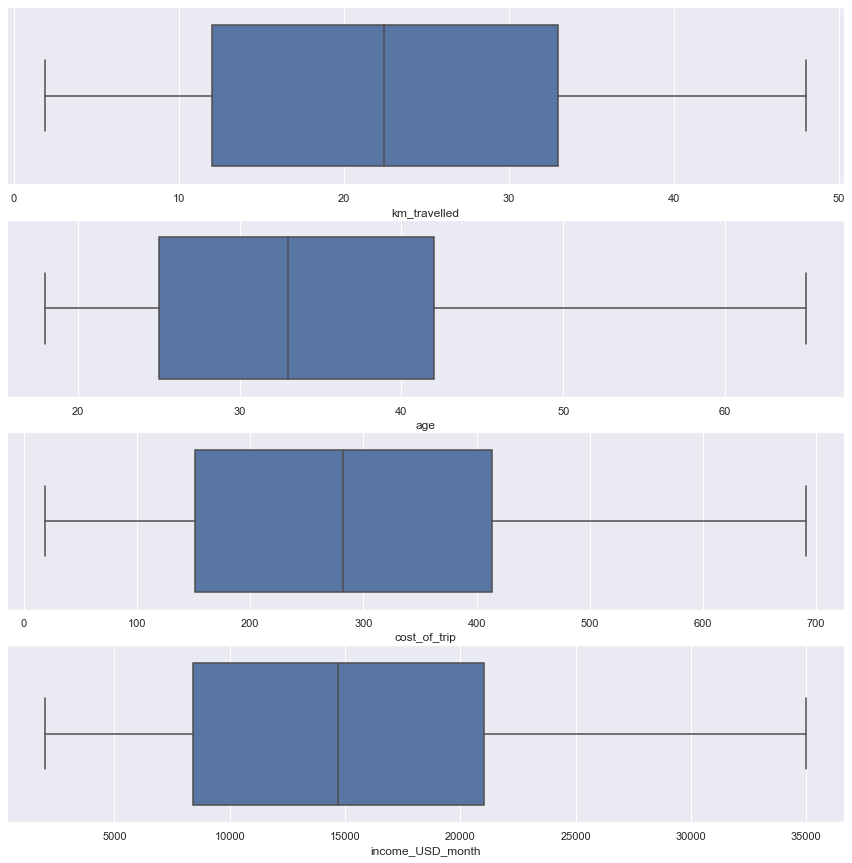

In [137]:
# km_travelled
plt.subplot(4,1,1)
sns.boxplot(df3['km_travelled'])

# age
plt.subplot(4,1,2)
sns.boxplot(df3['age'])

# # cost_of_trip'
plt.subplot(4,1,3)
sns.boxplot(df3['cost_of_trip'])

# # income_USD_month
plt.subplot(4,1,4)
sns.boxplot(df3['income_USD_month'])

<AxesSubplot:xlabel='day'>

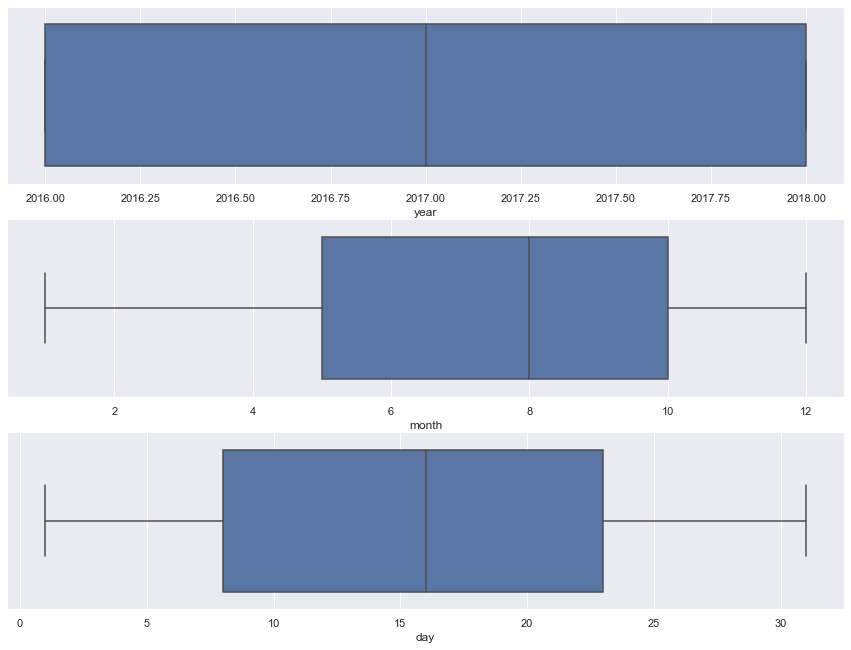

In [138]:
# year
plt.subplot(4,1,1)
sns.boxplot(df3['year'])

# # month
plt.subplot(4,1,2)
sns.boxplot(df3['month'])

# # day
plt.subplot(4,1,3)
sns.boxplot(df3['day'])

<AxesSubplot:xlabel='profit'>

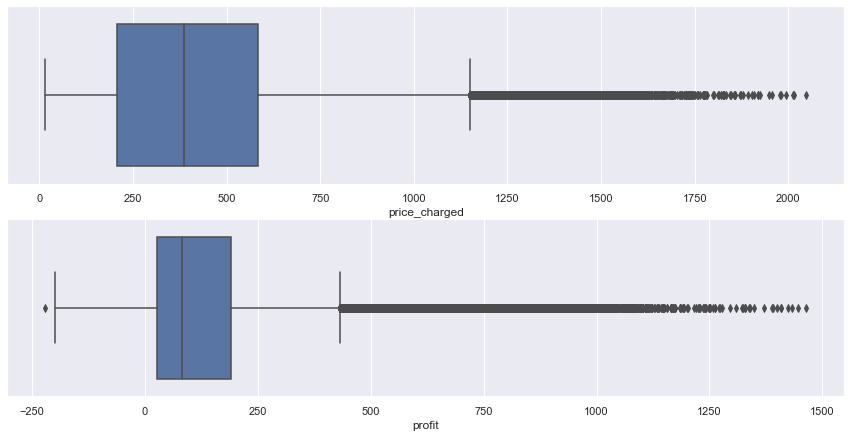

In [139]:
# price_charged
plt.subplot(4,1,1)
sns.boxplot(df3['price_charged'])

# # profit
plt.subplot(4,1,2)
sns.boxplot(df3['profit'])

In [25]:
#defining quartile or percentile
Q1, Q3 = np.percentile(df3['price_charged'], [25,75])
print('First quartile or percentile 25 is:',Q1)
print('Third quartile or percentile 75 is:',Q3)

amp_interquartile = Q3 - Q1
print(amp_interquartile)

# determinating inferirior and superior limit
inferior_limit = Q1 - (1.5 * amp_interquartile)
superior_limit = Q3 + (1.5 * amp_interquartile)
print('Inferirior limit is:',inferior_limit)
print('Superior limit is:',superior_limit)

First quartile or percentile 25 is: 206.4375
Third quartile or percentile 75 is: 583.66
377.22249999999997
Inferirior limit is: -359.39625
Superior limit is: 1149.49375


In [26]:
#defining quartile or percentile
Q1, Q3 = np.percentile(df3['profit'], [25,75])
print('First quartile or percentile 25 is:',Q1)
print('Third quartile or percentile 75 is:',Q3)

amp_interquartile = Q3 - Q1
print(amp_interquartile)

# determinating inferirior and superior limit
inferior_limit = Q1 - (1.5 * amp_interquartile)
superior_limit = Q3 + (1.5 * amp_interquartile)
print('Inferirior limit is:',inferior_limit)
print('Superior limit is:',superior_limit)

First quartile or percentile 25 is: 28.012
Third quartile or percentile 75 is: 190.02999999999997
162.01799999999997
Inferirior limit is: -215.01499999999996
Superior limit is: 433.0569999999999


<AxesSubplot:xlabel='km_travelled', ylabel='price_charged'>

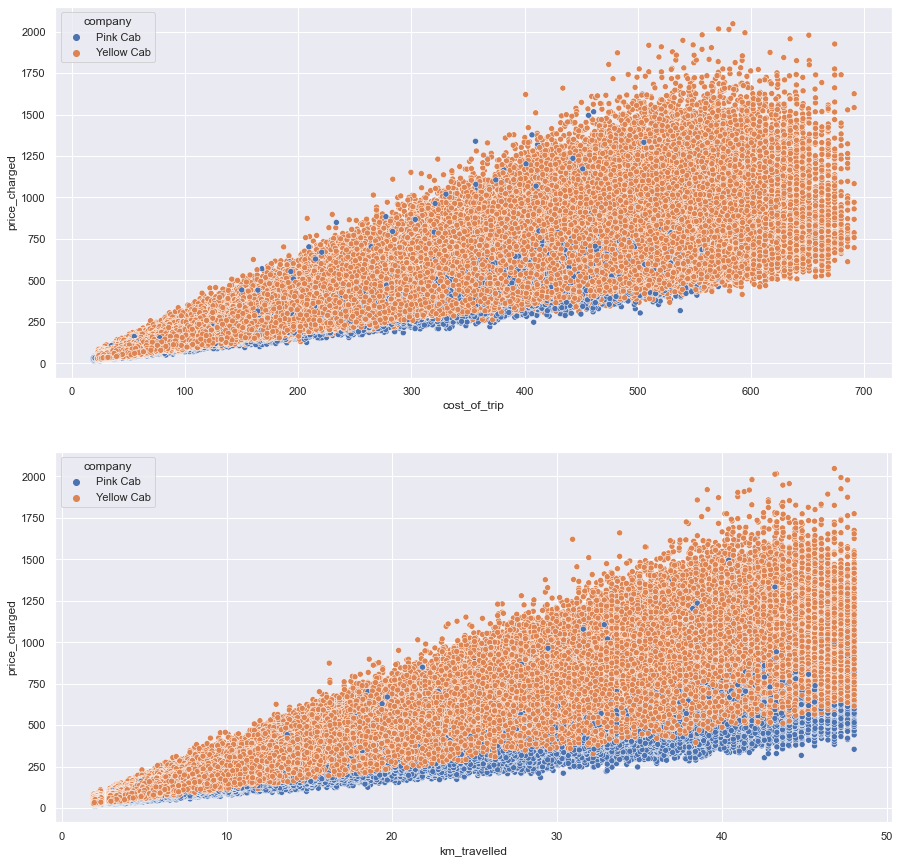

In [183]:
plt.subplot(2,1,1)
sns.scatterplot(x = 'cost_of_trip', y = 'price_charged', hue = 'company', data = df3)

plt.subplot(2,1,2)
sns.scatterplot(x = 'km_travelled', y = 'price_charged',  hue = 'company', data = df3)

<AxesSubplot:xlabel='km_travelled', ylabel='profit'>

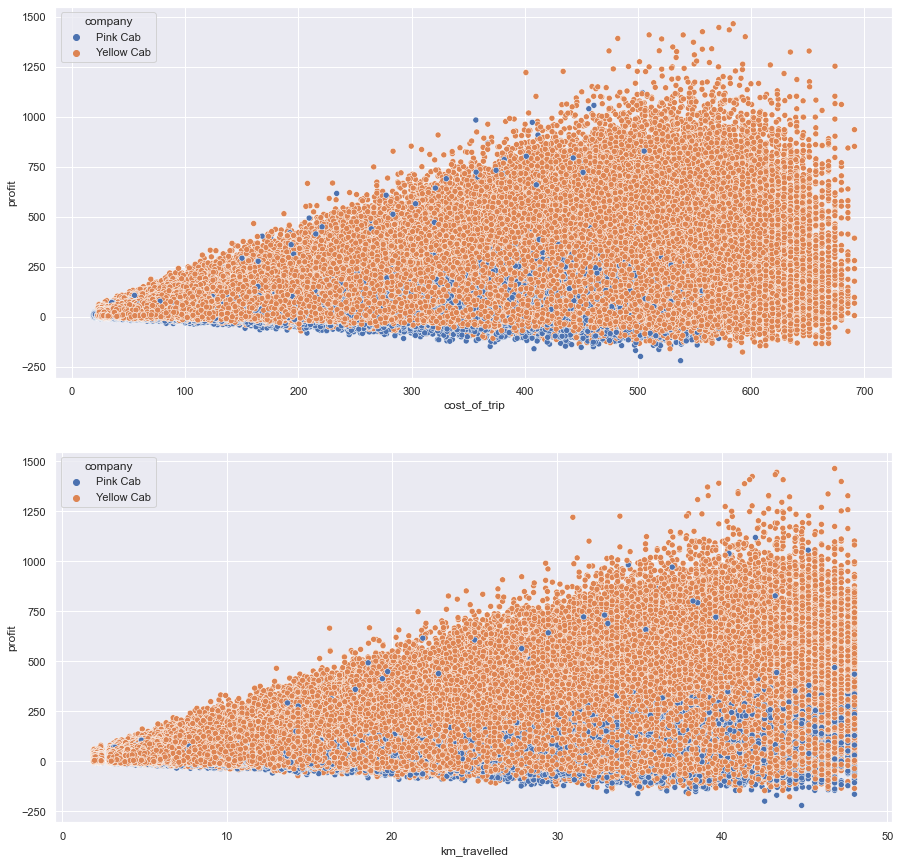

In [184]:
plt.subplot(2,1,1)
sns.scatterplot(x = 'cost_of_trip', y = 'profit', hue = 'company', data = df3)

plt.subplot(2,1,2)
sns.scatterplot(x = 'km_travelled', y = 'profit',  hue = 'company', data = df3)

Dispite the boxplot shows that there are a lots of outliers from a value of 1149 from the variable price charged and 433 from the variable profit, the others scatterplots shows a pattern of distribution, for both variables, with few outliers from value of arround 1750 (variable price charged) and 1250 (variable profit) just for the Yellow Cab company.

#Also the yellow company shows a number of travel so much higher than the Pink Cab.

For those reasons, it is not necessary exclude any outlier of this dataset.

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS (EDA)

In [30]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

<AxesSubplot:xlabel='profit', ylabel='Count'>

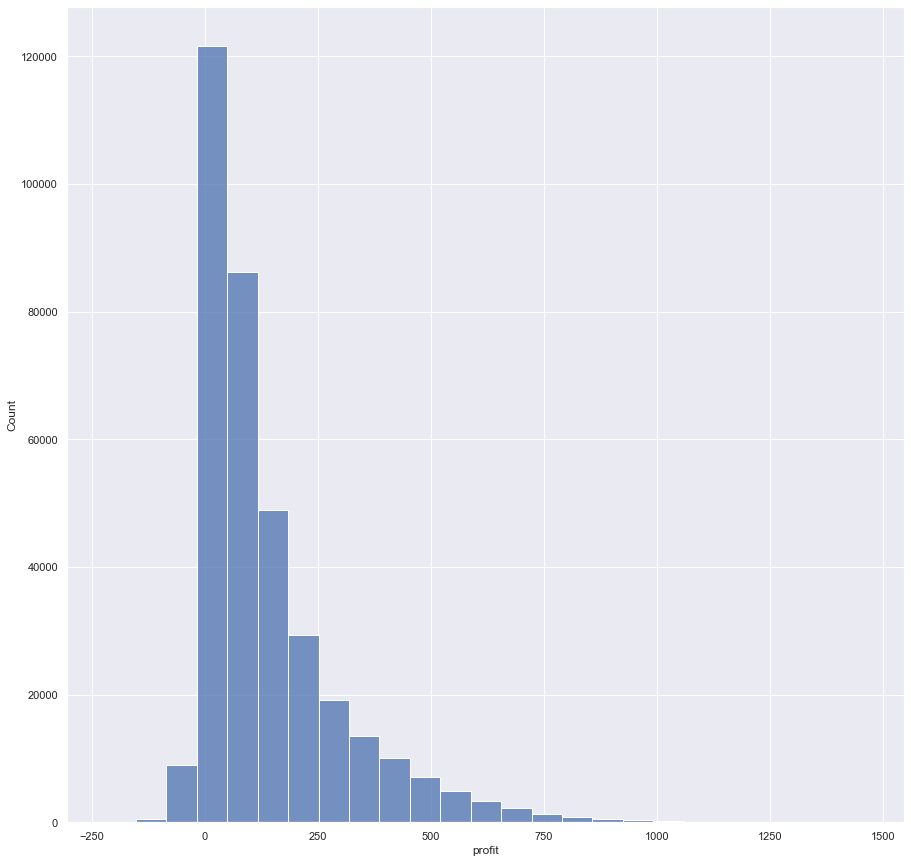

In [31]:
# ploting output variable
sns.set(rc={"figure.figsize": (15, 15)})
sns.histplot(df4['profit'], bins = 25)
# It has some kurtosis and presents a positive skew, which is to the left.

### 4.1.2. Numerical Variable

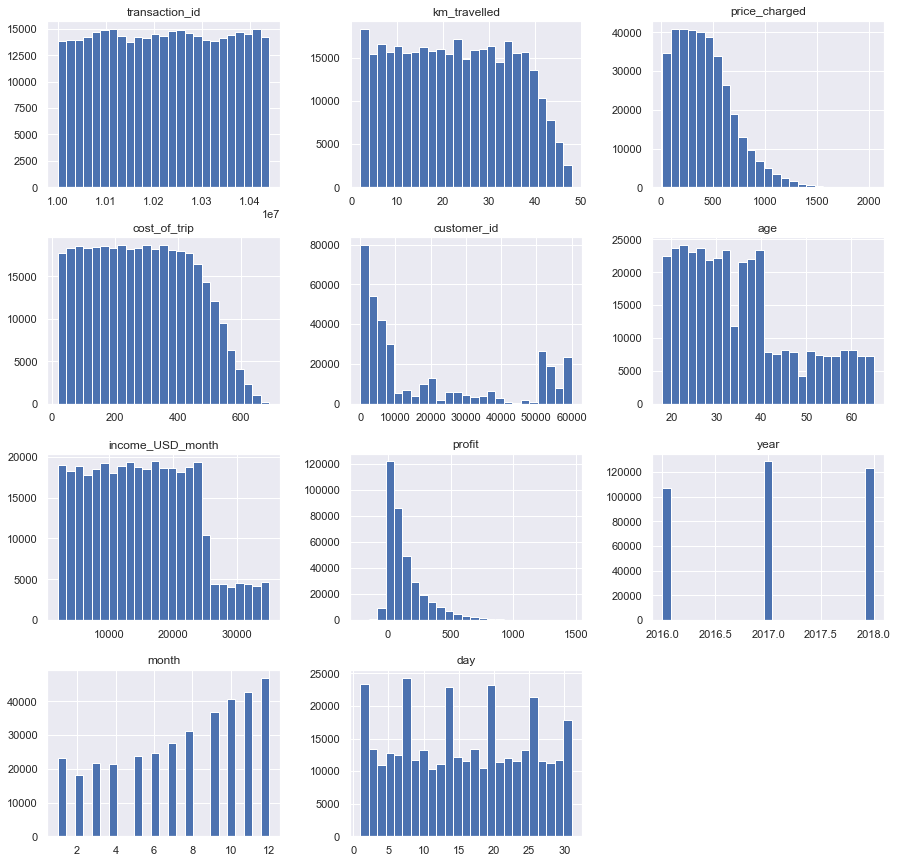

In [185]:
b = df4.select_dtypes(include=['int64', 'float64'])

sns.set(rc={"figure.figsize": (15, 15)})
b.hist(bins = 25);
# Histogram that shows the behavior of all the numerical variables.

### 4.1.3. CAtegorical Variable

In [33]:
c = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
c.apply(lambda x: x.unique().shape[0])

# The analysis of the categorical variables will serve to answer the business questions and create hypotheses.

company          2
city            19
payment_mode     2
gender           2
holiday         11
dtype: int64

## 4.2. - Business Questions

### 4.2.1. Question 1 - How many travels each company made trough this 3 years ?

      company  transaction_id  percentage
0    Pink Cab           84711       23.57
1  Yellow Cab          274681       76.43
The company Yellow Cab has 189970 (52.86%) more users than the company Pink Cab.


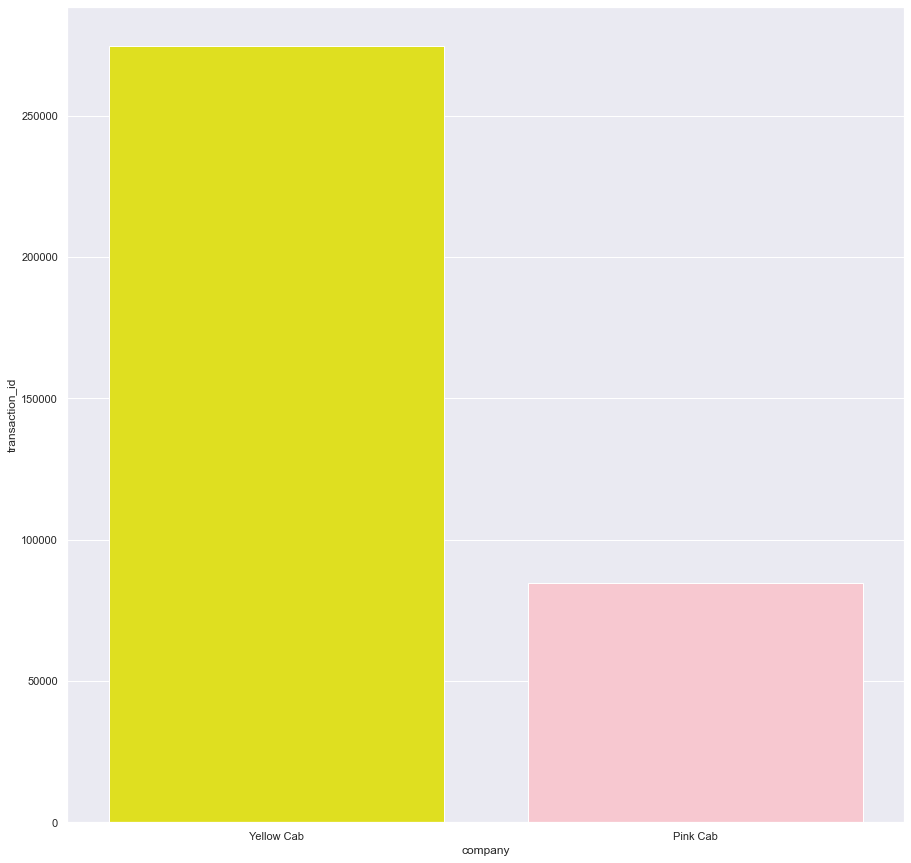

In [35]:
q1 = df4[['company', 'transaction_id']].groupby('company').count().reset_index()

for i in range(len(q1)):
    q1.loc[i,'percentage'] = (q1.loc[i, 'transaction_id']) /(sum(q1['transaction_id'])) * 100

q1_difference = q1.iloc[1,1] - q1.iloc[0,1]

q1_percentage = round(((q1.loc[1, 'transaction_id']) /(sum(q1['transaction_id'])) * 100) - ((q1.loc[0, 'transaction_id']) /(sum(q1['transaction_id'])) * 100), 2)

print(q1)
print('The company {} has {} ({}%) more users than the company {}.'.format(q1.iloc[1,0], q1_difference, q1_percentage, q1.iloc[0,0]))
sns.barplot(x = 'company', y = 'transaction_id', data = q1.sort_values('transaction_id', ascending = False), palette = ['yellow', 'pink']);

### 4.2.2. Question 2 - What is the total of money made by each company trough this 3 years?

      company      profit  percentage
0    Pink Cab  5307328.32       10.76
1  Yellow Cab 44020373.17       89.24
The company Yellow Cab has $38713044.8498 (78.48%) more profit than the company Pink Cab.


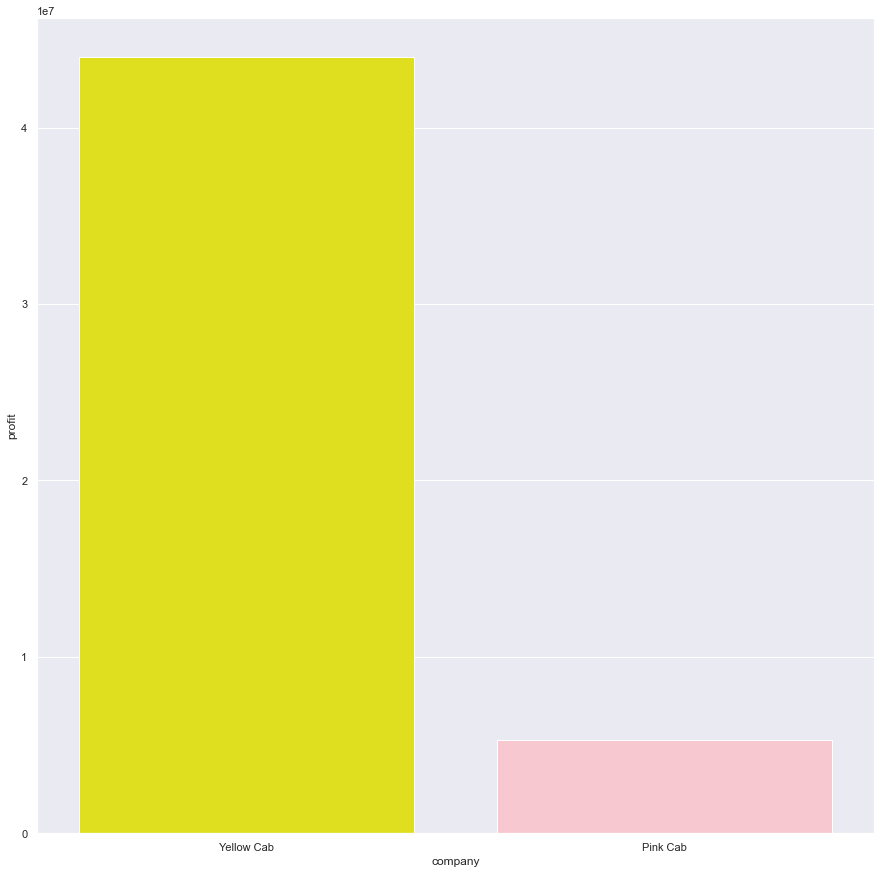

In [36]:
q2 = df4[['company', 'profit']].groupby('company').sum().reset_index()

for i in range(len(q2)):
    q2.loc[i,'percentage'] = (q2.loc[i, 'profit']) /(sum(q2['profit'])) * 100

q2_difference = q2.iloc[1,1] - q2.iloc[0,1]

q2_percentage = round(((q2.loc[1, 'profit']) /(sum(q2['profit'])) * 100) - ((q2.loc[0, 'profit']) /(sum(q2['profit'])) * 100), 2)

print(q2)
print('The company {} has ${} ({}%) more profit than the company {}.'.format(q2.iloc[1,0], q2_difference, q2_percentage, q2.iloc[0,0]))
sns.barplot(x = 'company', y = 'profit', data = q2.sort_values('profit', ascending = False), palette = ['yellow', 'pink']);

### 4.2.3. Question 3 - How many travels each company made trough this 3 years in each area?

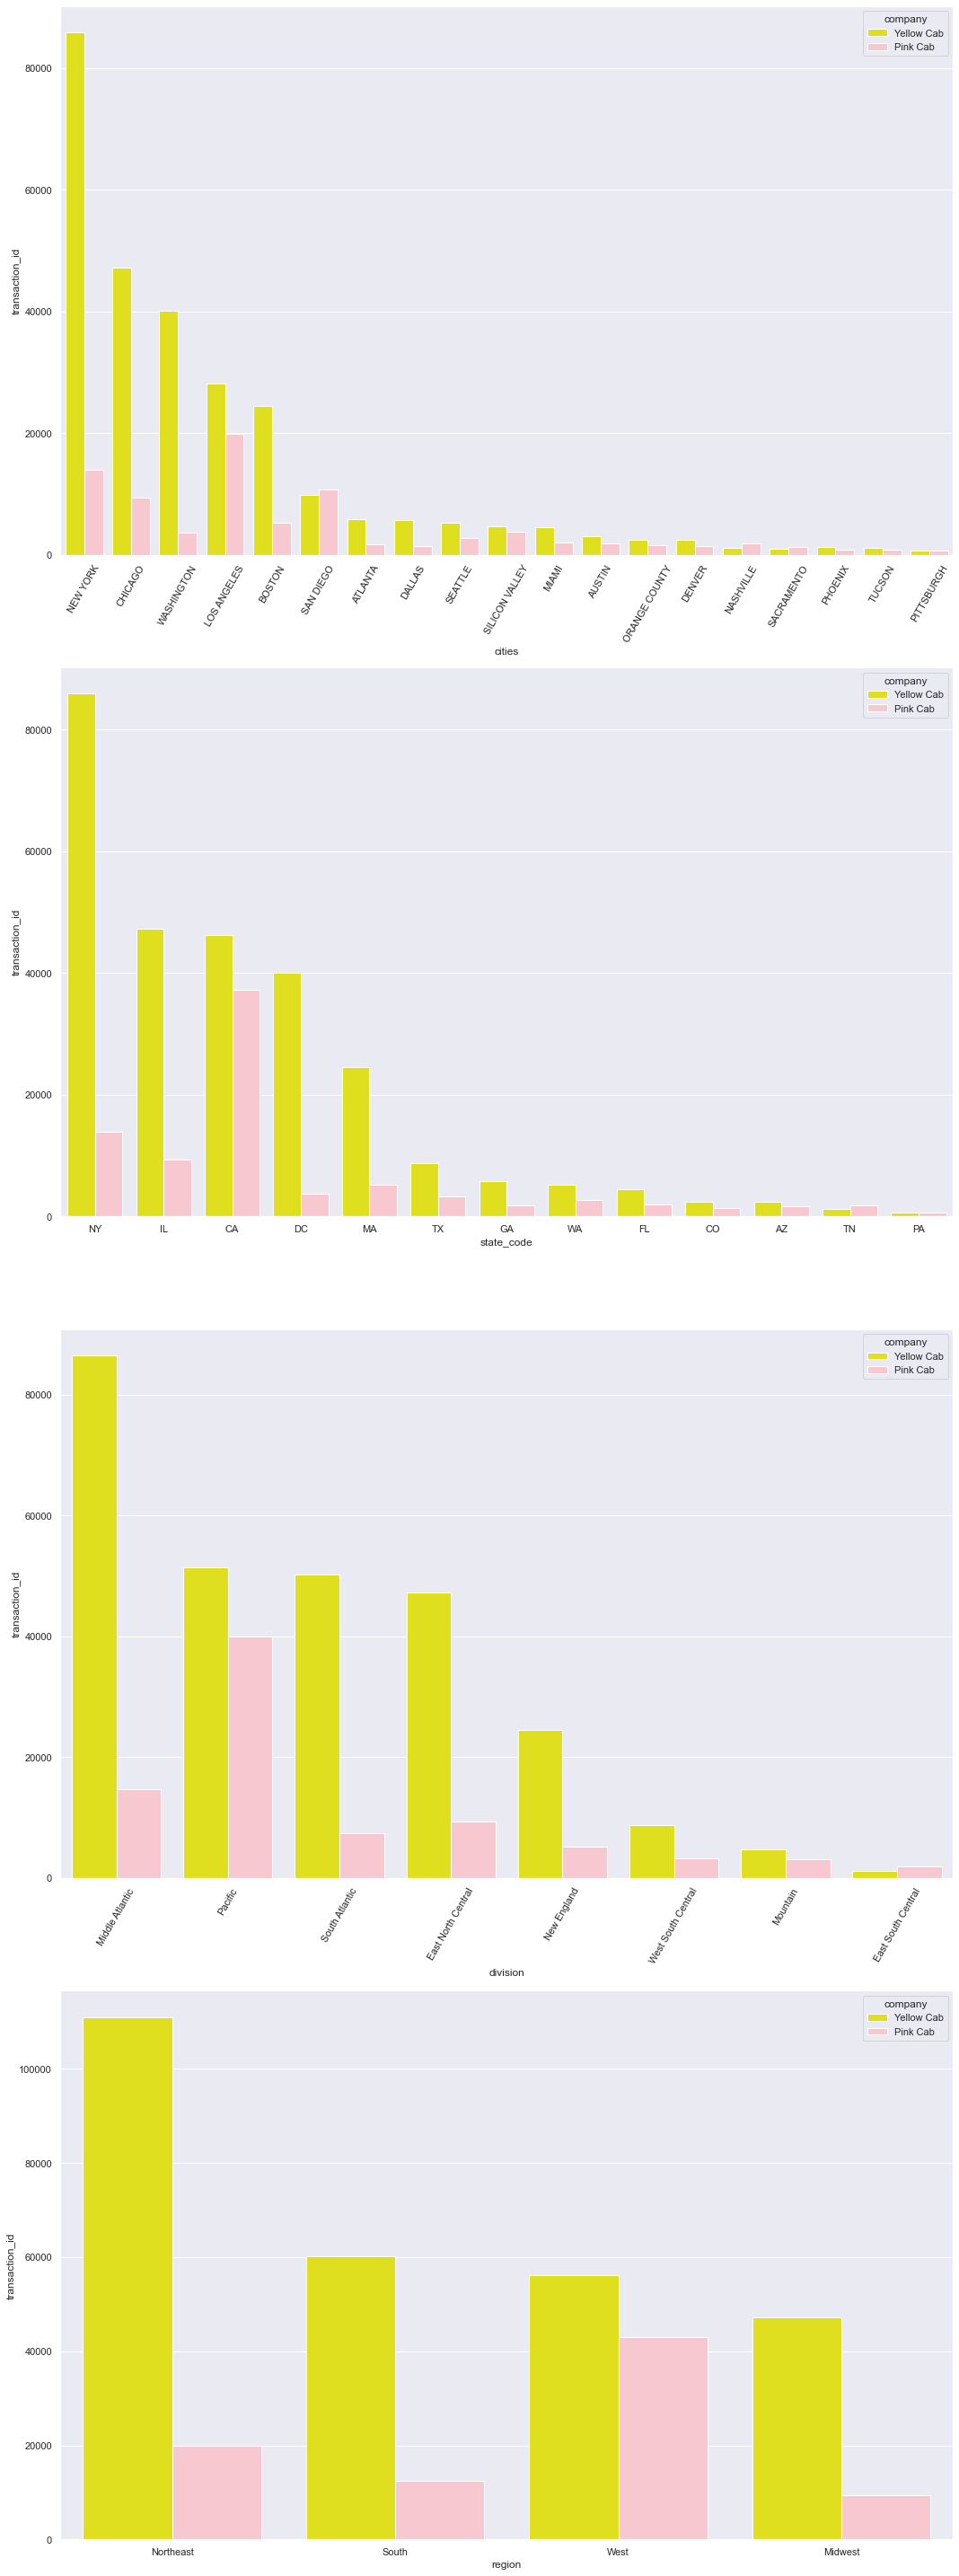

In [37]:
plt.figure(figsize = (15,40))
plt.subplot(4,1,1)
q3_1 = df4[['cities', 'transaction_id', 'company']].groupby(['cities', 'company']).count().reset_index()
sns.barplot(x = 'cities', y = 'transaction_id', hue = 'company', data = q3_1.sort_values('transaction_id', ascending = False), palette = ['yellow', 'pink']);
plt.xticks(rotation=60);

plt.subplot(4,1,2)
q3_2 = df4[['state_code', 'transaction_id', 'company']].groupby(['state_code', 'company']).count().reset_index()
sns.barplot(x = 'state_code', y = 'transaction_id', hue = 'company', data = q3_2.sort_values('transaction_id', ascending = False), palette = ['yellow', 'pink']);

plt.subplot(4,1,3)
q3_3 = df4[['division', 'transaction_id', 'company']].groupby(['division', 'company']).count().reset_index()
sns.barplot(x = 'division', y = 'transaction_id', hue = 'company', data = q3_3.sort_values('transaction_id', ascending = False), palette = ['yellow', 'pink']);
plt.xticks(rotation=60);

plt.subplot(4,1,4)
q3_4 = df4[['region', 'transaction_id', 'company']].groupby(['region', 'company']).count().reset_index()
sns.barplot(x = 'region', y = 'transaction_id', hue = 'company', data = q3_4.sort_values('transaction_id', ascending = False), palette = ['yellow', 'pink']);
plt.tight_layout()

### 4.2.4. Question 4 - Which area of US the Cab companies provide higher incomes?

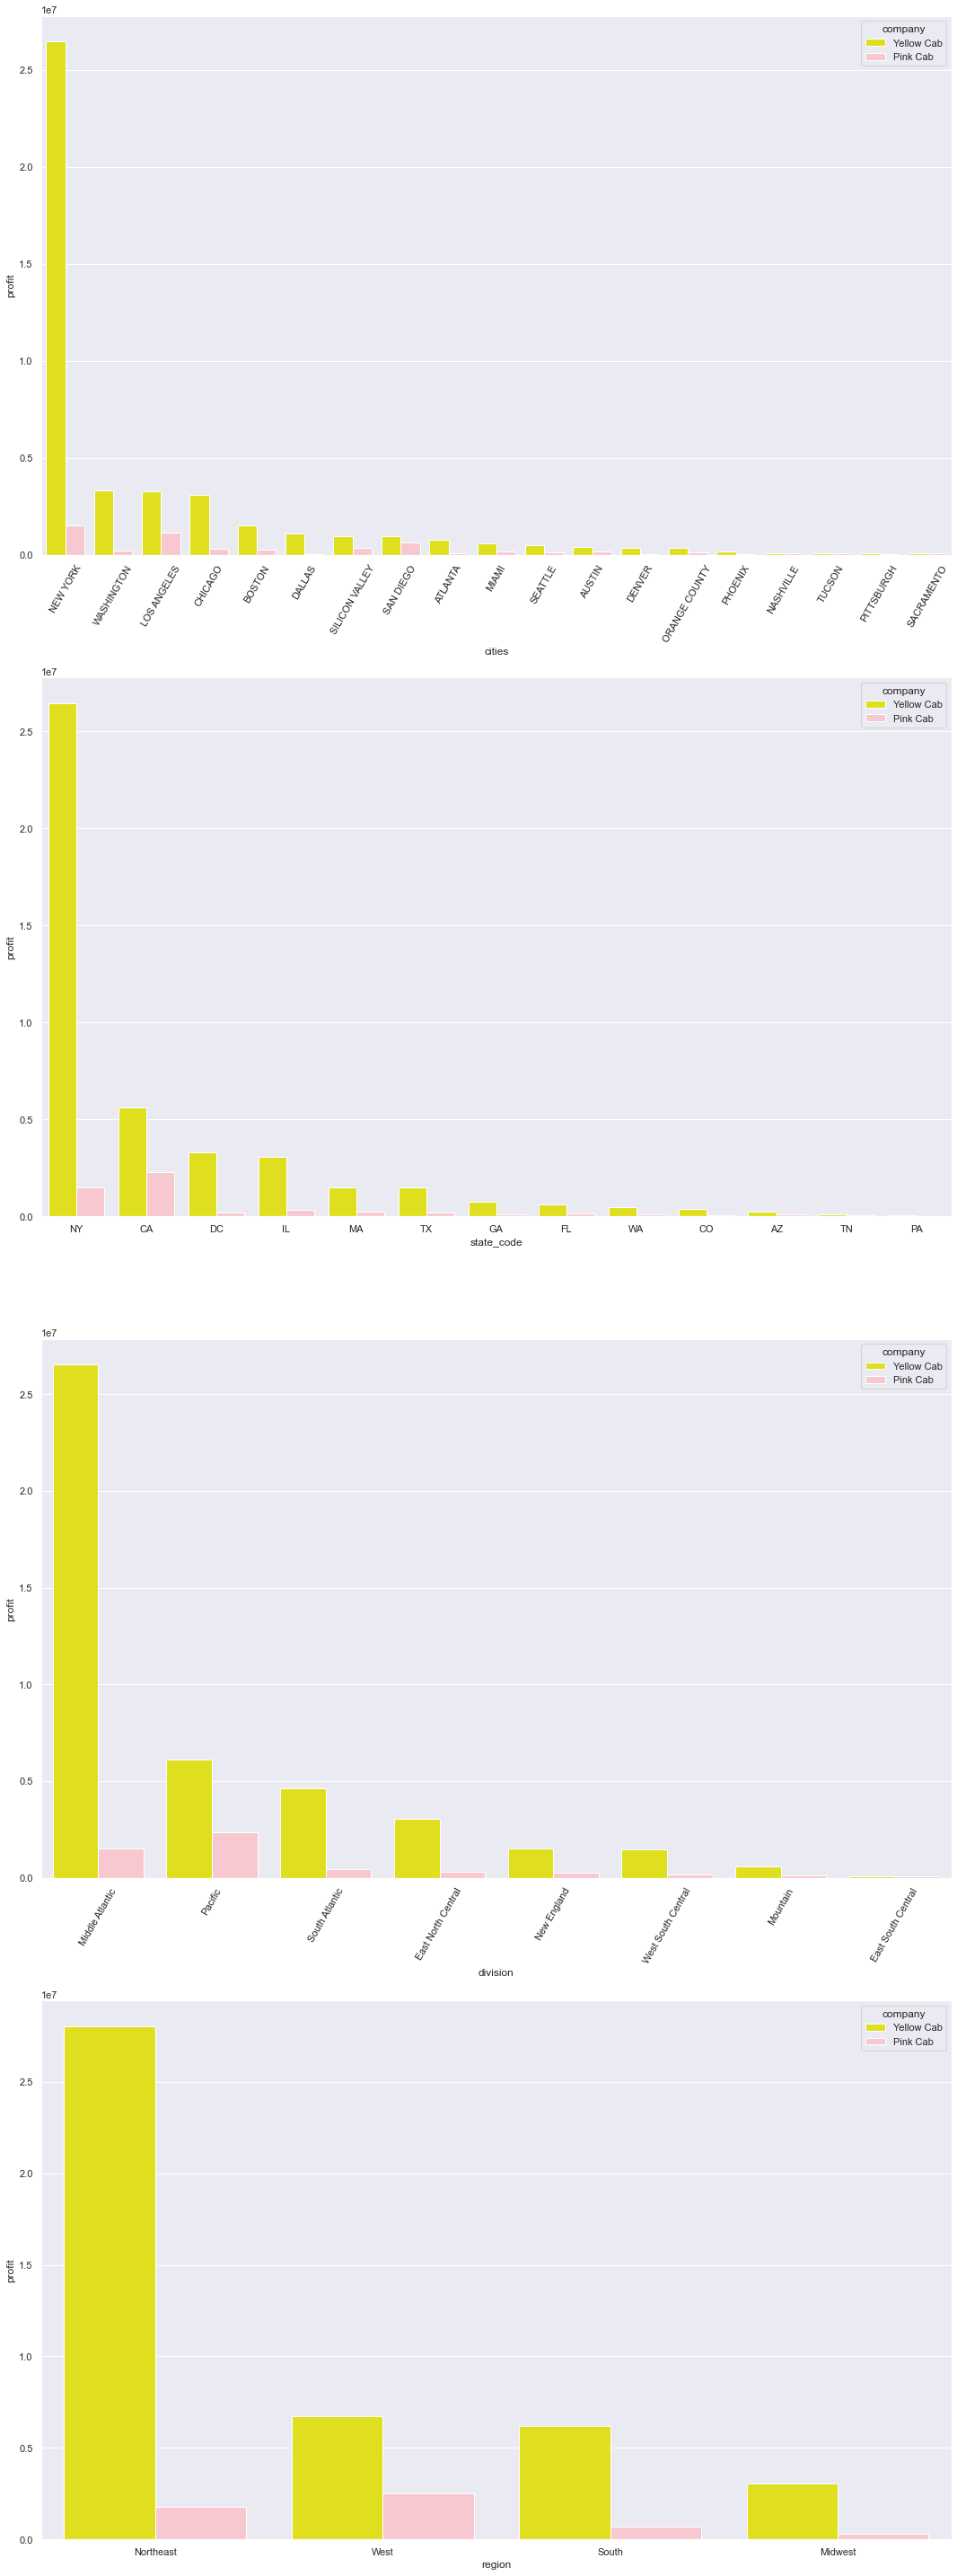

In [38]:
plt.figure(figsize = (15,40))
plt.subplot(4,1,1)
q4_1 = df4[['cities', 'profit', 'company']].groupby(['cities', 'company']).sum().reset_index()
sns.barplot(x = 'cities', y = 'profit', hue = 'company', data = q4_1.sort_values('profit', ascending = False), palette = ['yellow', 'pink']);
plt.xticks(rotation=60);

plt.subplot(4,1,2)
q4_2 = df4[['state_code', 'profit', 'company']].groupby(['state_code', 'company']).sum().reset_index()
sns.barplot(x = 'state_code', y = 'profit', hue = 'company', data = q4_2.sort_values('profit', ascending = False), palette = ['yellow', 'pink']);

plt.subplot(4,1,3)
q4_3 = df4[['division', 'profit', 'company']].groupby(['division', 'company']).sum().reset_index()
sns.barplot(x = 'division', y = 'profit', hue = 'company', data = q4_3.sort_values('profit', ascending = False), palette = ['yellow', 'pink']);
plt.xticks(rotation=60);

plt.subplot(4,1,4)
q4_4 = df4[['region', 'profit', 'company']].groupby(['region', 'company']).sum().reset_index()
sns.barplot(x = 'region', y = 'profit', hue = 'company', data = q4_4.sort_values('profit', ascending = False), palette = ['yellow', 'pink']);
plt.tight_layout()

### 4.2.5. Question 5 - How many travels each company has on each season?

   season     company  transaction_id
0    fall    Pink Cab           31239
1    fall  Yellow Cab           89172
2  spring    Pink Cab           13266
3  spring  Yellow Cab           53515
4  summer    Pink Cab           20206
5  summer  Yellow Cab           63506
6  winter    Pink Cab           20000
7  winter  Yellow Cab           68488


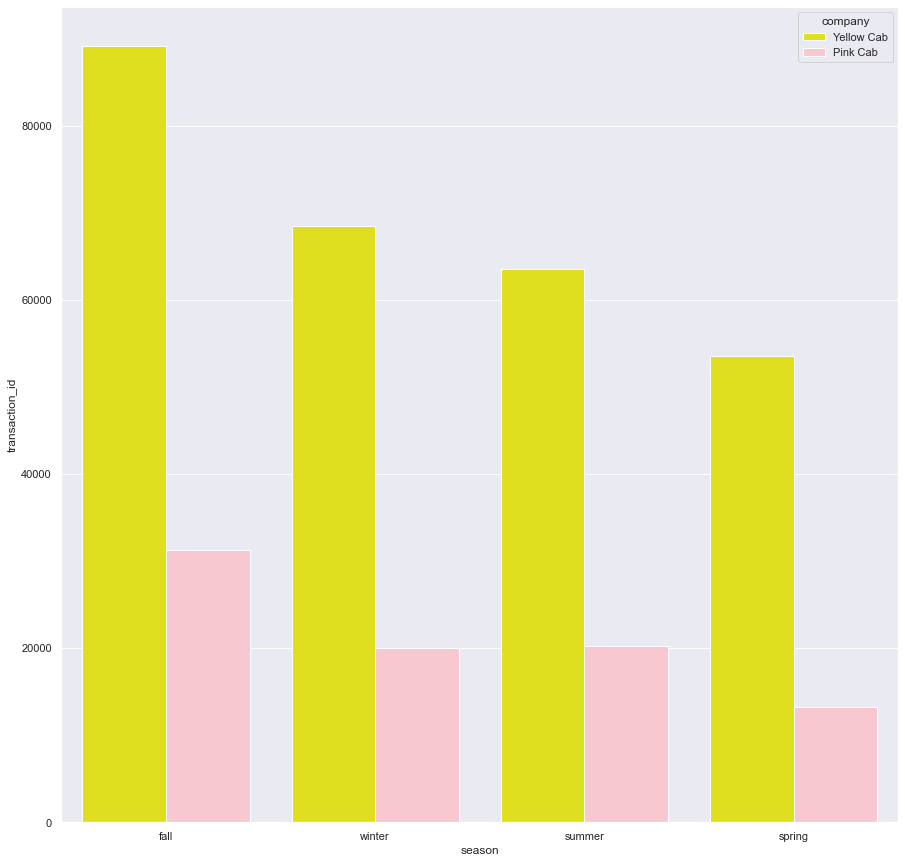

In [39]:
q5_1 = df4[['season', 'transaction_id', 'company']].groupby(['season', 'company']).count().reset_index()
print(q5_1)
sns.barplot(x = 'season', y = 'transaction_id', hue = 'company', data = q5_1.sort_values('transaction_id', ascending = False), palette = ['yellow', 'pink']);

### 4.2.6. Question 6 - Which season the Cab companies provide higher incomes?

   season     company      profit
0    fall    Pink Cab  2001198.57
1    fall  Yellow Cab 13002215.45
2  spring    Pink Cab   713528.58
3  spring  Yellow Cab 10210301.28
4  summer    Pink Cab   922851.63
5  summer  Yellow Cab  9298171.03
6  winter    Pink Cab  1669749.54
7  winter  Yellow Cab 11509685.41


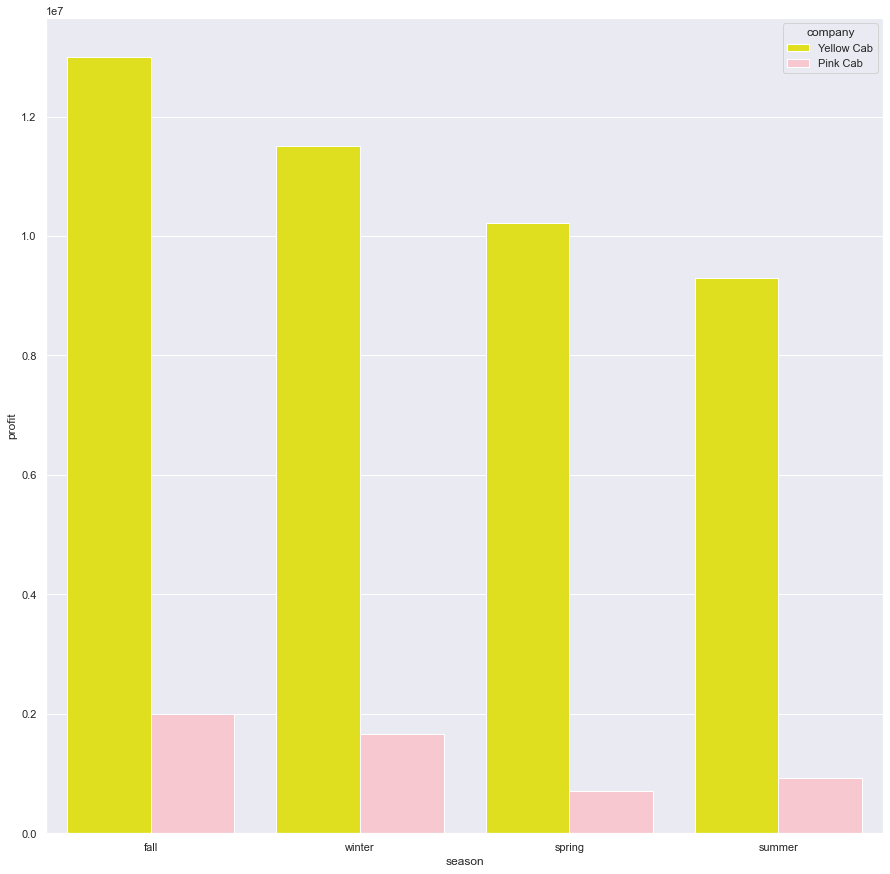

In [40]:
q6_1 = df4[['season', 'profit', 'company']].groupby(['season', 'company']).sum().reset_index()
print(q6_1)

sns.barplot(x = 'season', y = 'profit', hue = 'company', data = q6_1.sort_values('profit', ascending = False), palette = ['yellow', 'pink']);

In [41]:
# # aki mais pra frente cria-se um botao interativo no streamlit

# US_map = df4[['season', 'company', 'state_code', 'profit']]
# profit_sum= df4[['profit', 'state_code']].groupby('state_code').sum().reset_index()
# profit_sum.columns = ['state_code', 'profit_sum']
# US_map = pd.merge(US_map,profit_sum,on='state_code',how='inner')
# US_map = US_map.drop('profit', axis =1)
# US_map


# import ipywidgets as widgets
# from ipywidgets import interact, fixed
# from matplotlib import gridspec
# from matplotlib import pyplot as plt

# style = {'description_width': 'initial'}

# company_bar = widgets.Dropdown(options = US_map['company'].unique().tolist(),
#                                  value = 'Yellow Cab',
#                                  description = 'Cab Company',
#                                  disable = False,
#                                  style = style)

# season_bar = widgets.Dropdown(options = US_map['season'].unique().tolist(),
#                                  value = 'fall',
#                                  description = 'Season',
#                                  disable = False,
#                                  style = style)


# def update_map(US_map, c_limit, s_limit):
#     # condicoes dos botoes
#     mp = US_map[(US_map['company'] == c_limit) & (US_map['season'] == s_limit)][['season', 'company', 'state_code', 'profit_sum']].copy()
#     #criando o mapa
#     map = folium.Map(location=[48, -102], zoom_start=3)

#     map.choropleth(geo_data=geofile, data=mp,
#                  columns=['state_code', 'profit_sum'],
#                  key_on='feature.id',
#                  fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
#                  legend_name='Profit average')
#     return map

# widgets.interactive(update_map, data=fixed(US_map), c_limit = company_bar, s_limit =  season_bar)

In [42]:
# creating a map showing the price avarage at each state
# due the company Yellow Cab has more profit than Pink Cab company,
# and the season ... presents higher income, this map shows just the profit of Yellow Cab at season...

US_map = df4
US_map = US_map[(US_map['company'] == 'Yellow Cab') & (US_map['season'] == 'fall')]
US_map = US_map[['state_code', 'profit']].groupby(['state_code']).sum().reset_index()
print(US_map.sort_values('profit', ascending = False))

map = folium.Map(location=[48, -102], zoom_start=3)

map.choropleth(geo_data=geofile, data=US_map,
             columns=['state_code', 'profit'],
             key_on='feature.id',
             fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Profit average')
map

   state_code     profit
8          NY 8196813.75
1          CA 1566631.31
3          DC  792356.73
6          IL  749758.07
7          MA  483727.95
11         TX  432308.55
4          FL  216688.34
5          GA  208440.54
12         WA  123661.03
2          CO  103235.21
0          AZ   80421.73
10         TN   30797.76
9          PA   17374.48


### 4.2.7 - Answering the Business Questions

Yellow Cab company has a higher number of taxi trips than Pink Cab company, as well as a higher profit. 

The data also show that Yellow Cab has superior results in almost all cities, especially in New York, which is the city with the highest profit and number of taxi trips.

The same company also stands out from the other company in relation to the season, where the fall season shows the highest profit and number of taxi trips as well.

Due those all information, it is recommended to invest in Yellow Cab company.



## 4.3. - Hypotesis 

### 4.3.1. - Mind Map Hypotesis 

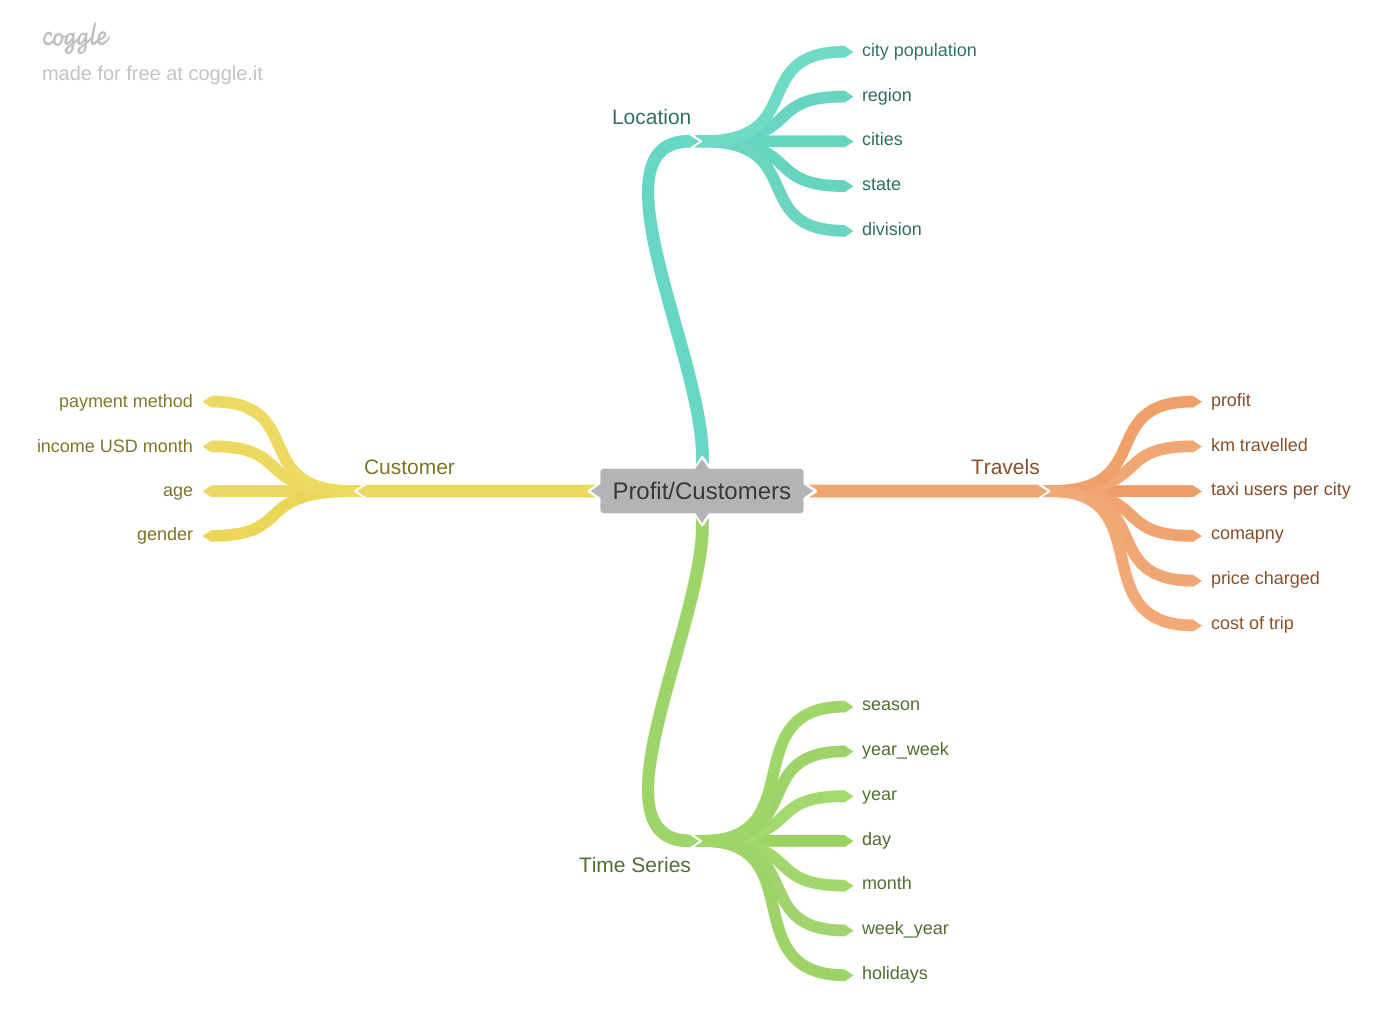

In [139]:
Image('img/MindMapHypothesis.png')

### 4.3.2. - Hypotesis Creation 

#### 4.3.2.1 - Travels Hypotesis

**H1.** The number of users of the Yellow Cab plus Pink Cab is the same number of the Total Cab Users at every cities.

**FALSE** There are others Cab company users at each state.

In [141]:
df_city_raw = pd.read_csv('DataSets/City.csv', low_memory=False)
df_city_raw['City'] = df_city_raw['City'].apply(lambda x: 'SILICON VALLEY CA' if x == 'SILICON VALLEY' else 
                                                          'ORANGE COUNTY CA' if x == 'ORANGE COUNTY'   else x)
H1 = df_city_raw
# spilt city in two columns
new = H1['City'].str.rsplit(" ", n = 1, expand = True)
  
# making separate first name column from new data frame
H1["cities"]= new[0]
  
# making separate last name column from new data frame
H1["State Code"]= new[1]

# Dropping old Name columns
H1.drop(columns =["State Code"], inplace = True)
H1.drop(columns =["City"], inplace = True)
H1.drop(columns =['Population'], inplace = True)
H1.drop(H1[H1['cities'] == 'SAN FRANCISCO'].index,inplace=True)

# droping duplicates on customer id and grouping it by cities
aux1 = df4.drop_duplicates(subset=['customer_id'])
aux2 = aux1[['cities', 'customer_id']].groupby(['cities']).count().reset_index()

# merge df_city_raw with dataset z
H1 = pd.merge(H1, aux2, how='left', on='cities')

#treating dataset
H1['Users'] = H1['Users'].replace(',','', regex=True)
H1['Users'] = H1['Users'].astype(np.float64)

#creating new variable
H1['others_cab_co'] = (H1['Users'] - H1['customer_id']).apply(lambda x : x)

# renaming variables
H1.columns = ['total_of_users', 'cities', 'pink_&_yellow_customers', 'customers_at_others_co']

#creating percentage customer_id variable
for i in range(len(H1)):
    H1.loc[i,'pink_&_yellow_customers_percent'] = ((H1.loc[i, 'pink_&_yellow_customers']) /(H1.loc[i, 'total_of_users'])) * 100
    
#creating percentage others_cab_co variable
for i in range(len(H1)):
    H1.loc[i,'customers_at_others_co_percent'] = ((H1.loc[i, 'customers_at_others_co']) /(H1.loc[i, 'total_of_users'])) * 100   

H1.sort_values('pink_&_yellow_customers_percent', ascending = False)

,total_of_users,cities,pink_&_yellow_customers,customers_at_others_co,pink_&_yellow_customers_percent,customers_at_others_co_percent
15,3643.00,PITTSBURGH,1068,2575.00,29.32,70.68
7,6133.00,PHOENIX,1515,4618.00,24.70,75.30
13,5712.00,TUCSON,1411,4301.00,24.70,75.30
14,7044.00,SACRAMENTO,1633,5411.00,23.18,76.82
17,9270.00,NASHVILLE,1869,7401.00,20.16,79.84
10,12421.00,DENVER,2171,10250.00,17.48,82.52
5,12994.00,ORANGE COUNTY,2216,10778.00,17.05,82.95
11,14978.00,AUSTIN,2419,12559.00,16.15,83.85
3,17675.00,MIAMI,2680,14995.00,15.16,84.84
8,22157.00,DALLAS,2743,19414.00,12.38,87.62


**H2.** The number of users of the Yellow Cab is higher than the company Pink Cab  in each citie.

**FALSE** There are cities where the Pink cab company has more customers than the Yellow cab company, cities such: San Diego, Nashville, Sacramento and Pitsburgh.

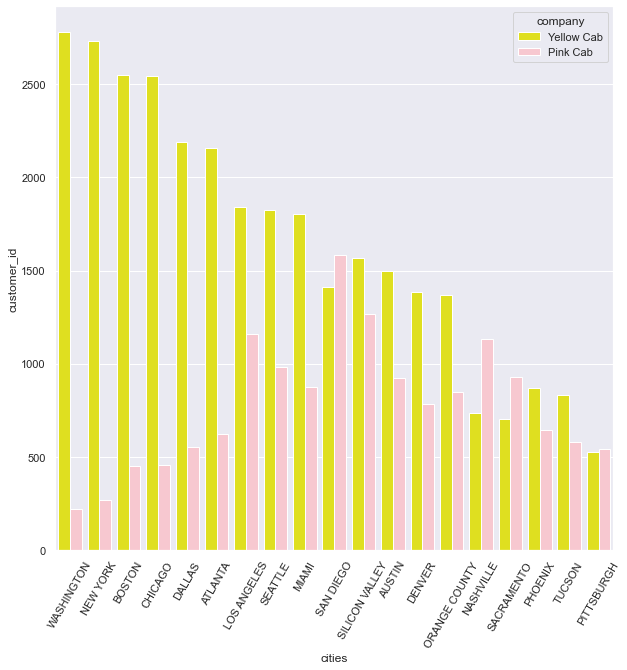

In [171]:
aux3 = df4.drop_duplicates(subset=['customer_id'])
H2 = aux3[['cities', 'customer_id', 'company']].groupby(['cities', 'company']).count().reset_index()

sns.barplot(x = 'cities', y = 'customer_id', hue = 'company', data = H2.sort_values('customer_id', ascending = False), palette = ['yellow', 'pink']);
plt.xticks(rotation=60);

#### 4.3.2.2 - Time Series Hypotesis

**H3.** People uses more taxi during New Year's Day than other holidays in all 3 years.

**FALSE** In total, the holiday which people uses more taxis is Veterans Day, However, spliting this in years, 2016 and 2018, Thanksgiving Day is the holiday wich  people uses more taxis, and in 2017 the holiday is Veterans Day.

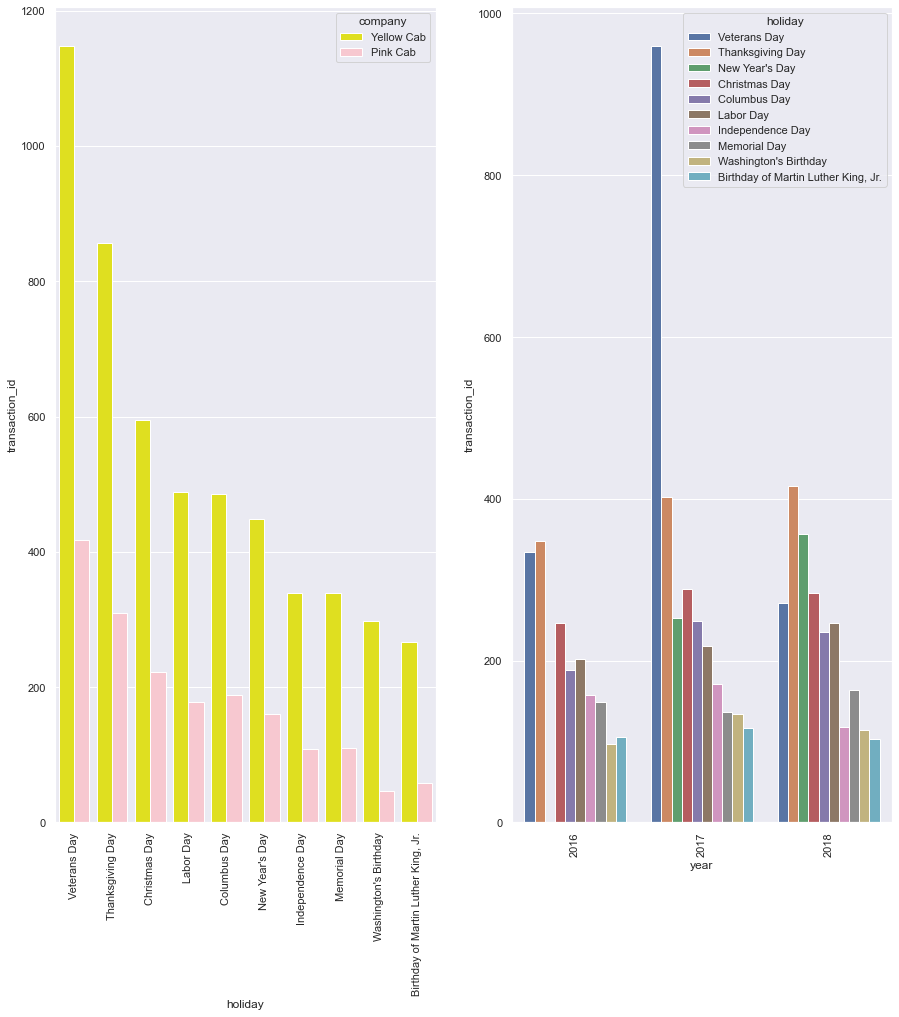

In [143]:
aux = df4[df4['holiday'] != 'Regular day']

plt.subplot(1,2,1)
H3_1 = aux[['holiday', 'transaction_id', 'company']].groupby(['holiday', 'company']).count().reset_index()
sns.barplot(x = 'holiday', y = 'transaction_id', hue = 'company', data = H3_1.sort_values('transaction_id', ascending = False), palette = ['yellow', 'pink']);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
H3_2 = aux[['year', 'holiday', 'transaction_id']].groupby(['year', 'holiday']).count().reset_index()
sns.barplot(x = 'year', y = 'transaction_id', hue = 'holiday', data = H3_2.sort_values('transaction_id', ascending = False));
plt.xticks(rotation=90);

**H4.** The number of users for each company increases WoW (Week over Week).

**FALSE** The number of users for each company decreases over the weeks-year.

<AxesSubplot:xlabel='year_week'>

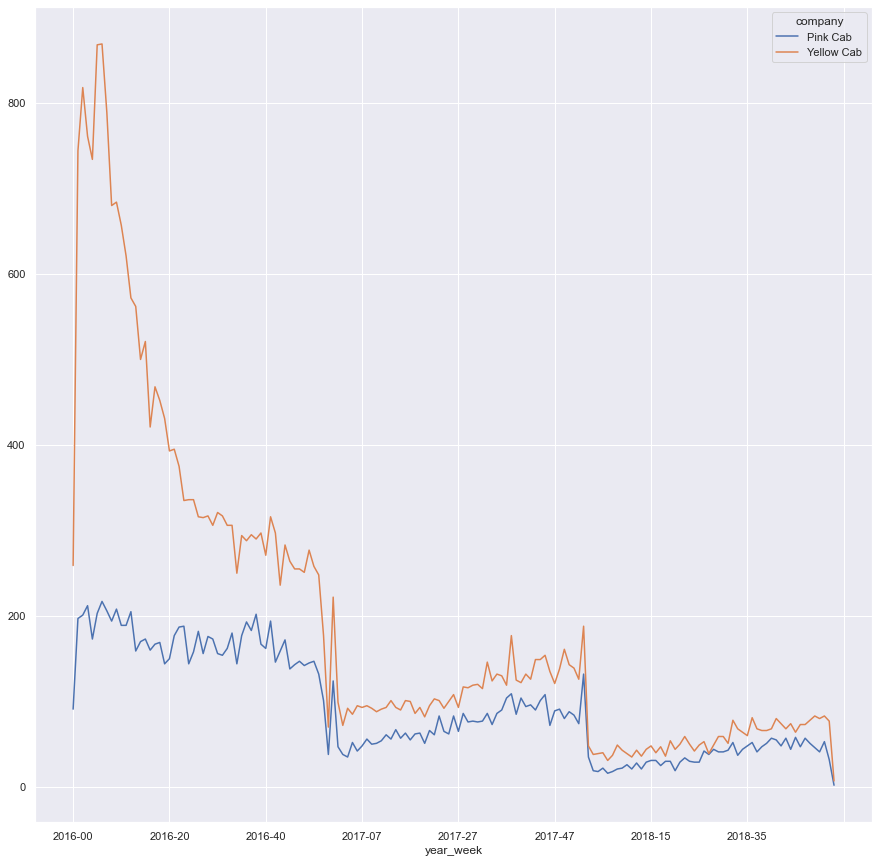

In [144]:
aux = df4.drop_duplicates(subset=['customer_id'])

H4 = aux[['customer_id','year_week', 'company']].groupby(['year_week', 'company']).count().reset_index()
H4_1 = H4.pivot(index = 'year_week', columns = 'company', values = 'customer_id')
H4_1.plot()

**H5.** The amount of money made by the cab companies increase YoY (Year over Year) and MoM (Month over Month).

**FALSE** The amount of money suffer a increase until the midle of the period of time than starts to decrese.

<AxesSubplot:xlabel='year_month'>

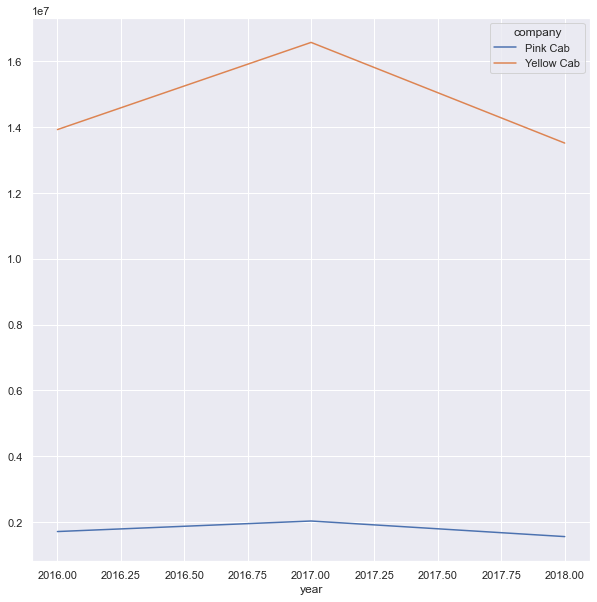

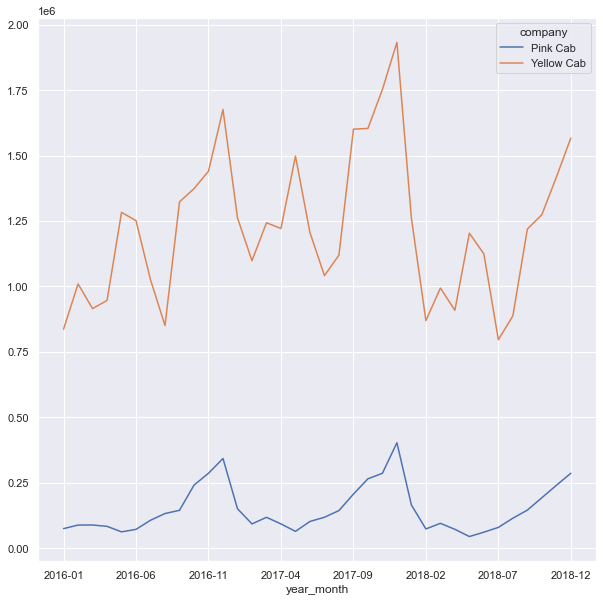

In [172]:
sns.set(rc={"figure.figsize": (10, 10)})

H5_1 = df4[['profit','year', 'company']].groupby(['year', 'company']).sum().reset_index()
H5_1_1 = H5_1.pivot(index = 'year', columns = 'company', values = 'profit')
H5_1_1.plot()

H5_2 = df4[['profit','year_month', 'company']].groupby(['year_month', 'company']).sum().reset_index()
H5_2_1 = H5_2.pivot(index = 'year_month', columns = 'company', values = 'profit')
H5_2_1.plot()



**H6.** The number of travels made by the cab companies increase YoY (Year over Year) and MoM (Month over Month).

**FALSE** The number of travels for each company suffer a increase until the midle of the period of time and than keep stable, decreasing just little bit.

<AxesSubplot:xlabel='year_month'>

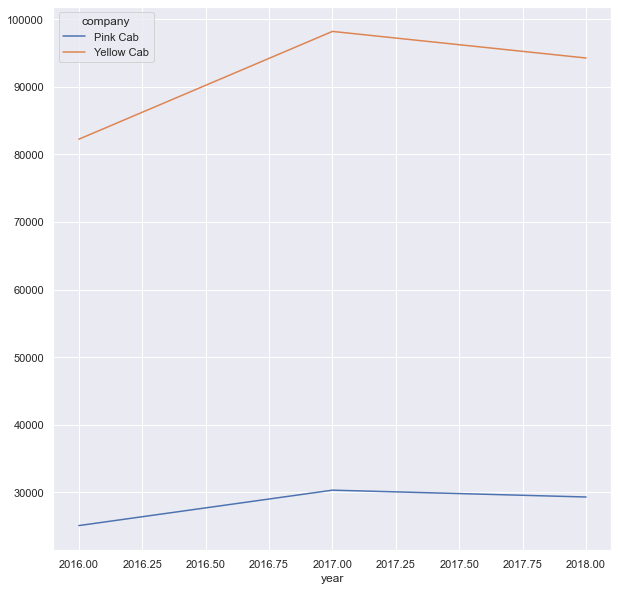

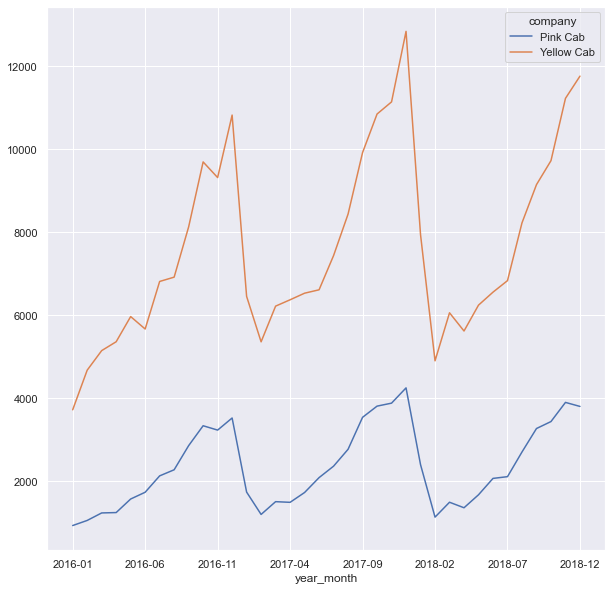

In [174]:
sns.set(rc={"figure.figsize": (10, 10)})

H6_1 = df4[['transaction_id','year', 'company']].groupby(['year', 'company']).count().reset_index()
H6_1_1 = H6_1.pivot(index = 'year', columns = 'company', values = 'transaction_id')
H6_1_1.plot()

H6_2 = df4[['transaction_id','year_month', 'company']].groupby(['year_month', 'company']).count().reset_index()
H6_2_1 = H6_2.pivot(index = 'year_month', columns = 'company', values = 'transaction_id')
H6_2_1.plot()

**H7.**  Companies make more profit during second semester of the year.

**TRUE** Companies make more during second semester of the year.

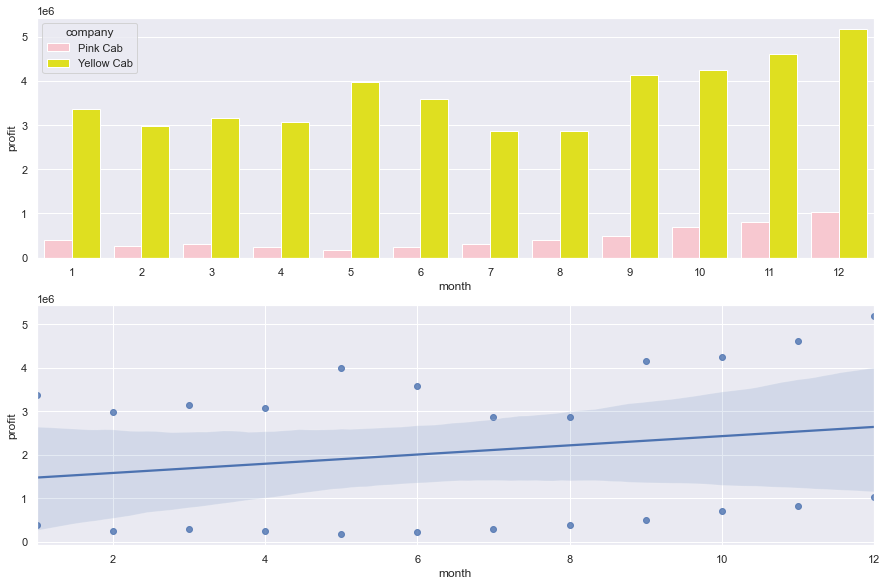

In [103]:
H7 = df4[['month', 'profit', 'company']].groupby(['month', 'company']).sum().reset_index()

plt.subplot(3,1,1)
sns.barplot(x = 'month', y = 'profit', hue = 'company', data = H7, palette = ['pink', 'yellow']);

plt.subplot(3,1,2)
sns.regplot(x = 'month', y = 'profit', data = H7);

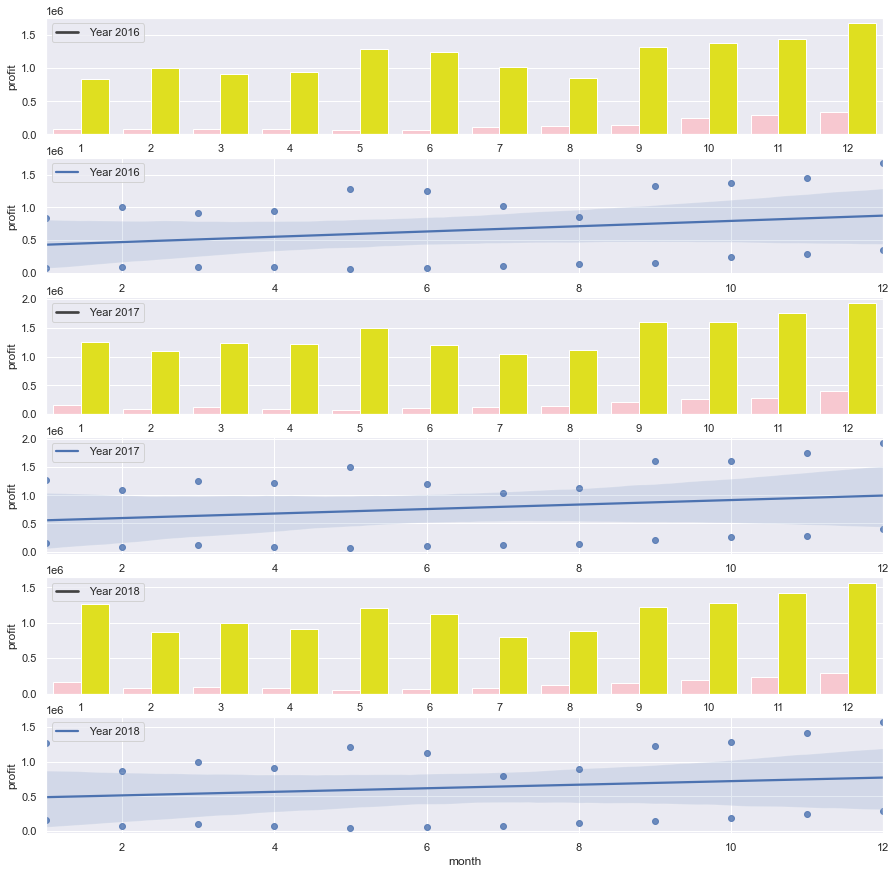

In [106]:
H7_1 = df4[df4['year'] == 2016]
H7_2 = df4[df4['year'] == 2017]
H7_3 = df4[df4['year'] == 2018]


H7_1 = H7_1[['month', 'profit', 'company']].groupby(['month', 'company']).sum().reset_index()

plt.subplot(6,1,1)
ax1 = sns.barplot(x = 'month', y = 'profit', hue = 'company', data = H7_1, palette = ['pink', 'yellow']);
ax1.legend(labels =[' Year 2016'])

plt.subplot(6,1,2)
ax2 = sns.regplot(x = 'month', y = 'profit', data = H7_1);
ax2.legend(labels =[' Year 2016'])

H7_2 = H7_2[['month', 'profit', 'company']].groupby(['month', 'company']).sum().reset_index()

plt.subplot(6,1,3)
ax3 = sns.barplot(x = 'month', y = 'profit', hue = 'company', data = H7_2, palette = ['pink', 'yellow']);
ax3.legend(labels =[' Year 2017'])

plt.subplot(6,1,4)
ax4 = sns.regplot(x = 'month', y = 'profit', data = H7_2);
ax4.legend(labels =[' Year 2017'])

H7_3 = H7_3[['month', 'profit', 'company']].groupby(['month', 'company']).sum().reset_index()

plt.subplot(6,1,5)
ax5 = sns.barplot(x = 'month', y = 'profit', hue = 'company', data = H7_3, palette = ['pink', 'yellow']);
ax5.legend(labels =[' Year 2018'])

plt.subplot(6,1,6)
ax6 = sns.regplot(x = 'month', y = 'profit', data = H7_3);
ax6.legend(labels =[' Year 2018'])

#### 4.3.2.3 - Customers Series Hypotesis

**H8.**  People with the amount of income higher than the median uses more taxis.

**FALSE** People with the amount of income higher than the median uses less taxis than people which has income inferior than median, however this difference is minimal.

  income_is_higher_than_median     company  customer_id
0                           no    Pink Cab         7415
1                           no  Yellow Cab        15661
2                          yes    Pink Cab         7414
3                          yes  Yellow Cab        15658
For the company Pink Cab, the number of customers which income is inferior than median is 1 more than customers which income is inferior than median.
For the company Yellow Cab, the number of customers which income is inferior than median is 3 more than customers which income is inferior than median.


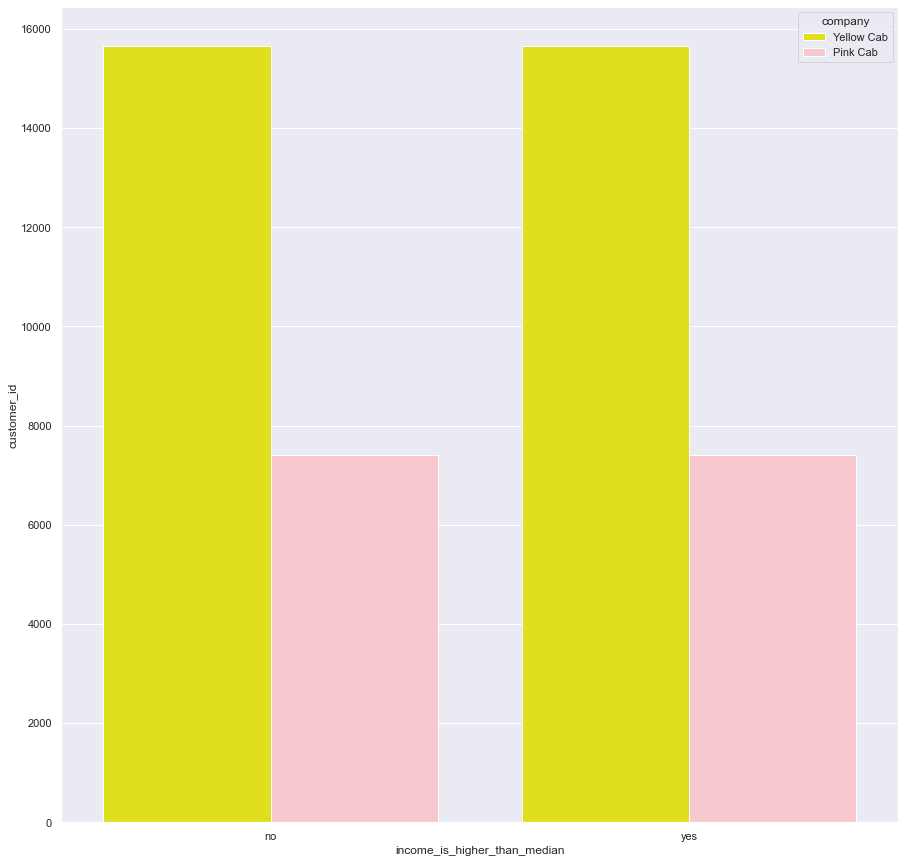

In [149]:
aux = df4.drop_duplicates(subset=['customer_id'])
income_USD_median =aux[['income_USD_month', 'company']].groupby('company').median().reset_index()
income_USD_median.columns = ['company', 'income_median']

H8 = pd.merge(aux,income_USD_median,on='company',how='inner')
        
H8['income_is_higher_than_median'] = H8.apply(lambda x: 'yes' if (x['income_USD_month'] > x['income_median']) else
                                                   'no', axis = 1)

H8_1 = H8[['customer_id', 'income_is_higher_than_median', 'company']].groupby(['income_is_higher_than_median', 'company']).count().reset_index()
H8_1

H8_1_1_difference = H8_1.iloc[1,2] - H8_1.iloc[3,2]
H8_1_2_difference = H8_1.iloc[0,2] - H8_1.iloc[2,2]

print(H8_1)
print('For the company Pink Cab, the number of customers which income is inferior than median is {} more than customers which income is inferior than median.'.format(H8_1_2_difference))
print('For the company Yellow Cab, the number of customers which income is inferior than median is {} more than customers which income is inferior than median.'.format(H8_1_1_difference))
sns.barplot(x = 'income_is_higher_than_median', y = 'customer_id', hue = 'company', data = H8_1.sort_values('customer_id', ascending = False), palette = ['yellow', 'pink']);

**H9.**  Men uses more cash than women for payment.

**TRUE** Men uses more cash than women.

  payment_mode  gender  transaction_id
0         Card  Female           92025
1         Card    Male          123479
2         Cash  Female           61455
3         Cash    Male           82433


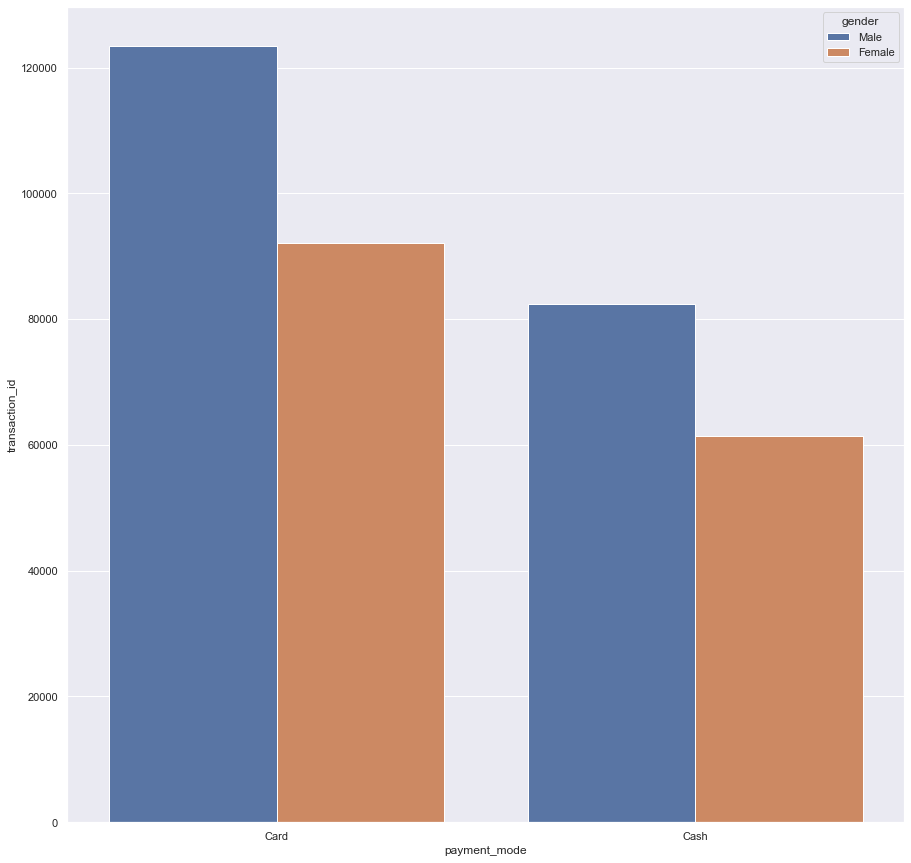

In [168]:
H9 = df4[['transaction_id', 'gender', 'payment_mode']].groupby(['payment_mode', 'gender']).count().reset_index()
print(H9)

sns.barplot(x = 'payment_mode', y = 'transaction_id', hue = 'gender', data = H9.sort_values('transaction_id', ascending = False));

**H10.**  Young people uses more taxis than old people.

**TRUE.**  Young people uses more taxis than old people.

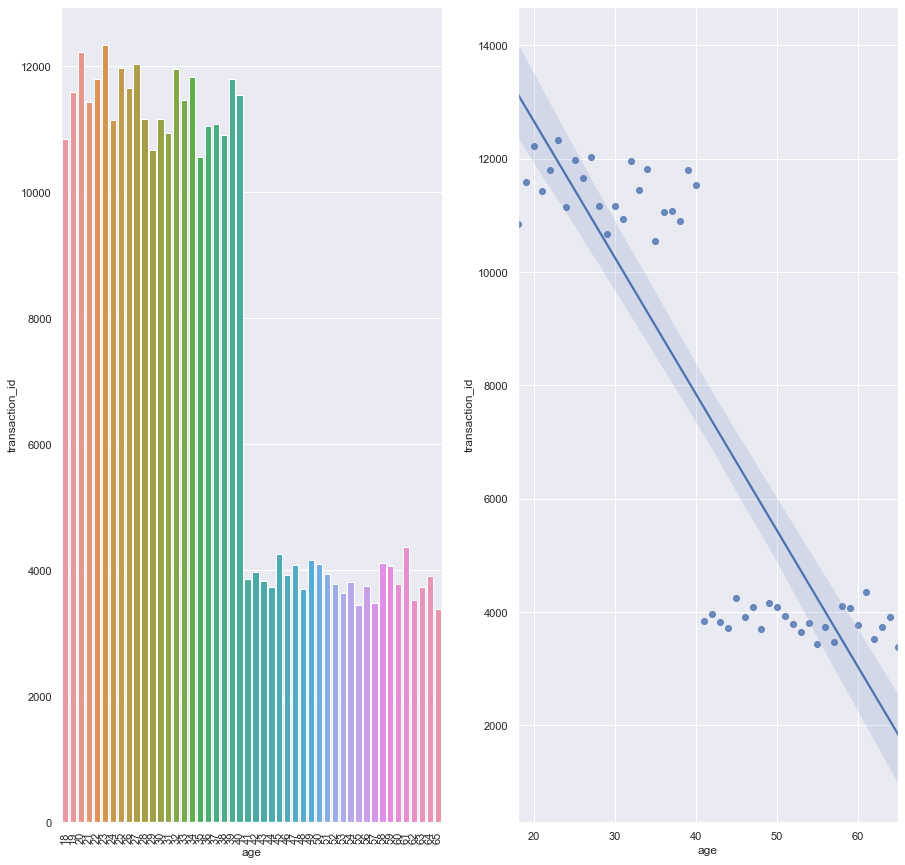

In [180]:
aux1 = df4[['age', 'transaction_id']].groupby('age').count().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'age', y = 'transaction_id', data = aux1);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.regplot(x = 'age', y = 'transaction_id', data = aux1);